Here, you develop the exact spatial derivative operator and its unit test. (Develop a quantitative assessment between what you've already found here for the Fourier derivative and the known derivative.)

In [1]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML


sys.path.append('/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/')
from Modules import BasicTools as BT
from Modules import WaveTools as WT
from Modules import PlotTools as PT
from Modules import FFTTools as FFTT
from Modules import OperatorTools as OT
from Modules import GridTransferTools as GTT
from Modules import TestTools as TT
from Modules import SolverTools as ST
from Modules import WaveformTools as WFT

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 10000, threshold = 100000)

Set parameters.

In [2]:
nh = 32
refRatio = 2
c = 1.
CFL = 0.5
nt = 1
RK = 4
deriv = 'CD'
order = 0
mu = 0.5
sigma = .1
wavenumber = 13


# Grid parameters.
nh_min = 64
refRatio = 2
cfInter = int(nh_min / refRatio)

# Time integration parameters.
CFL = np.sqrt(0.5)
nt = 50
deriv = 'CD'
RK = 4
order = 2

# Waveform parameters.
x_0 = 0.
x_1 = float(cfInter) / float(nh_min)

# Physical parameters.
L = 1e-3
locs = []#x_1]
epsilons_r = [1]#, 11.68]
mus_r = [1]#, 0.99837]

# Pseudo-FFT parameters.
Hans = False

In [3]:
omega = BT.Grid(nh)
finehalf = list(np.arange(int(nh / refRatio)) + int(nh / refRatio))
omega.AddPatch(refRatio, finehalf)

physics = BT.PhysProps(omega, epsilons_r, mus_r, locs, L)

waves = WT.MakeWaves(omega)
nullspace = OT.FindNullspace(omega, waves)
# cMat = physics.cMat

In [4]:
# For Gaussian:
# waveform = WFT.Gauss(omega, sigma, mu)
# waveDeriv = WFT.Gauss(omega, sigma, mu, BooleAve = True, deriv = True)

# For Gaussian wavepacket:
waveform = WFT.WavePacket(omega, sigma, mu, wavenumber)
waveDeriv = WFT.WavePacket(omega, sigma, mu, wavenumber, deriv = True)

In [5]:
derivMat = OT.ExactSpatDerivOp(omega) # Works on fine grid to produce results on AMR grid!
spatOp = c * derivMat
# testDeriv = TT.ExactSpatDeriv(omega, t, waveform, -1, order)
# THIS IS A PROBLEM FOR NEW RK SETUP!!!

FCoefs = nullspace @ FFTT.FourierCoefs(waves @ nullspace, waveform)
FCoefsDeriv = nullspace @ FFTT.FourierCoefs(waves @ nullspace, waveDeriv)
FCoefsTestDeriv = spatOp @ FCoefs# FFTT.FourierCoefs(waves @ nullspace, testDeriv)
allCoefs = PT.Load(FCoefs, FCoefsDeriv, FCoefsTestDeriv)
labels = ['Initial Waveform', 'Exact Derivative', 'Fourier Derivative']

You are using ExactSpatDerivOp in OperatorTools module (which I believe is what you want)!
[[  0.  -0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.  -1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   1.   0.  -0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  

Are you *sure* your labels are ordered correctly?


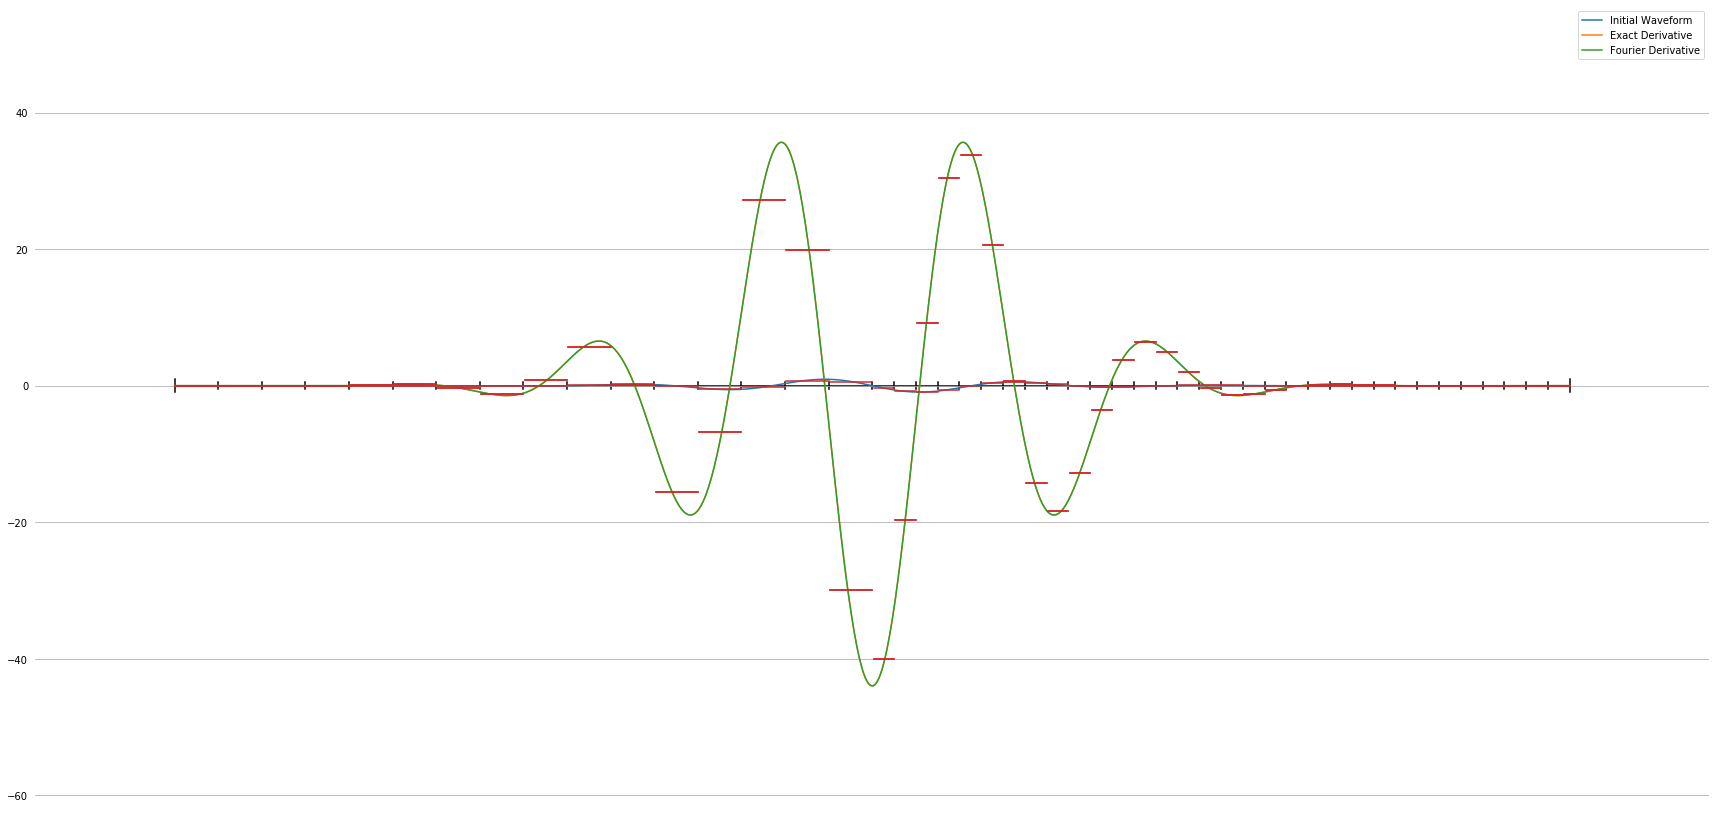

In [6]:
PT.PlotMixedWave(omega, waves, allCoefs, rescale = 6, yGrid = True, labels = labels)#, saveName = 'GaussTest', dpi = 300)


In [7]:
what = (waves @ FCoefsTestDeriv) / (waves @ FCoefsDeriv)
print(FCoefsTestDeriv)
print(FCoefs)
print(what)
print('')

[ 0.00000000e+00 -1.76946022e-06  1.28632084e-03  3.59221256e-06 -2.26540610e-02 -6.06100388e-06  2.00801950e-01  9.09764092e-06 -1.06609023e+00 -1.46928742e-05  3.57547859e+00  2.28819008e-05 -7.75701577e+00 -3.08122022e-05  1.10247015e+01  2.37563718e-05 -1.03426517e+01  1.19021811e-06  6.43580479e+00 -2.79491431e-05 -2.66518259e+00  3.47167920e-05  7.36247832e-01 -2.97342900e-05 -1.35924390e-01  1.91085915e-05  1.67808142e-02 -1.59564463e-05 -1.39813287e-03  6.23368433e-06  6.21113411e-05 -2.72945587e-05 -8.05567825e-06  4.39671460e-07  7.29778135e-06 -7.18643016e-06  6.24277697e-07  8.68180306e-07  2.39827898e-07 -5.03079961e-06  2.05182168e-06  6.11412840e-08 -1.45885399e-06 -3.78042488e-06  3.08000453e-06 -1.27744765e-06 -2.29799189e-06 -2.89544161e-06  3.95597537e-06 -3.36799781e-06 -2.86839798e-06 -2.17552602e-06  4.77557377e-06 -7.01489162e-06 -3.35266989e-06 -1.50978964e-06  5.59001026e-06 -1.52252943e-05 -3.83029143e-06 -8.13663592e-07  6.43130218e-06 -5.49707654e-05 -4.3448